In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras.utils as utils
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import Conv2D, MaxPool2D

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

# 1. CNN 특징 맵, 풀링 맵 시각화 하기

In [2]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train/255
X_test = X_test/255

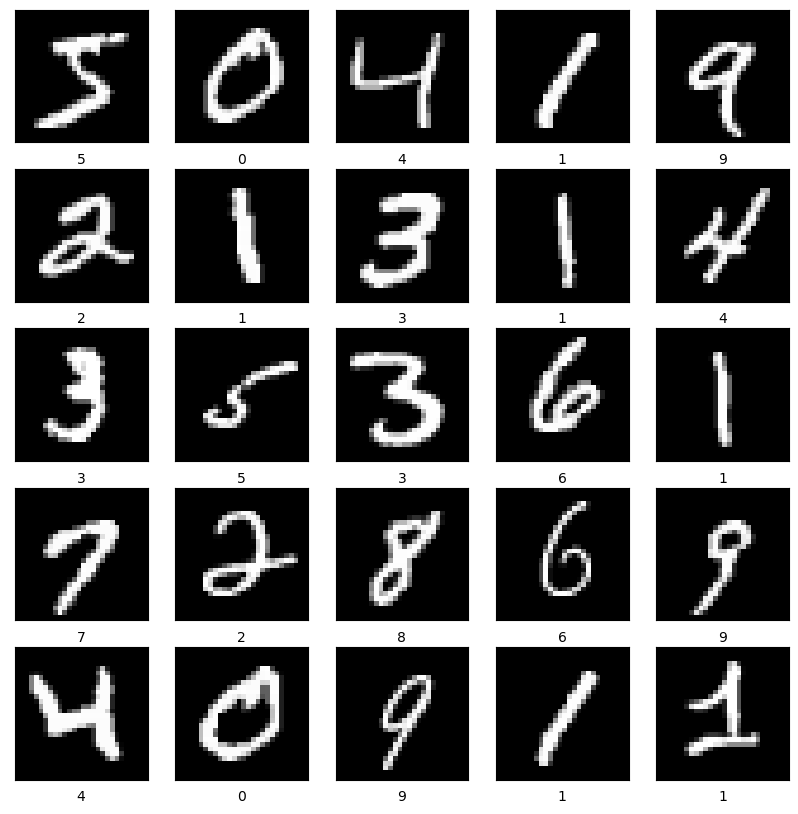

In [3]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(str(y_train[i]))

- C P C P C P F D
- filters = 32, 64, 64
- filter size : 3 * 3
- padding : same
- optimizer : Adam(lr=0.01)

In [4]:

from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train/255
X_test = X_test/255

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [5]:
model = Sequential()


model.add(Conv2D(filters=32, kernel_size=3, padding="SAME", input_shape=(28, 28, 1), activation="relu"))

model.add(MaxPool2D(padding="SAME"))
model.add(Dropout(0.25))


model.add(Conv2D(filters=64, kernel_size=3, padding="SAME", input_shape=(28, 28, 1), activation="relu"))

model.add(MaxPool2D(padding="SAME"))
model.add(Dropout(0.25))


model.add(Conv2D(filters=64, kernel_size=3, padding="SAME", input_shape=(28, 28, 1), activation="relu"))

model.add(MaxPool2D(padding="SAME"))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(10, activation="softmax"))

model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

## (1) 학습 전 feature map 시각화

In [6]:
print(model.layers[1].name)
print(model.layers[2].name)
print(model.layers[3].name)

max_pooling2d
dropout
conv2d_1


In [7]:
for layer in model.layers:
    if "conv" in layer.name:
        print(layer.name, layer.output.shape)

conv2d (None, 28, 28, 32)
conv2d_1 (None, 14, 14, 64)
conv2d_2 (None, 7, 7, 64)


In [8]:
partial_model = Model(inputs=model.inputs, outputs=model.layers[0].output)
partial_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


8617


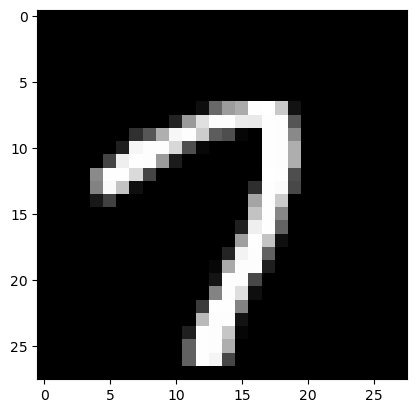

In [9]:
rnd_idx = np.random.randint(0, len(X_test))
print(rnd_idx)

plt.imshow(X_test[rnd_idx], cmap="gray")

In [10]:
feature_map = partial_model.predict(X_test[rnd_idx].reshape(-1,28,28,1))
feature_map.shape

# filter가 32개로 처음에 설정해줬기 때문에 마지막 채널 수가 32, (1, 28, 28, 32(채널 수))
# (1, 28, 28, 32) = (28, 28)의 사이즈의 채널을 32개 가진 image가 1개있다,

1/1 [==============================] - 0s 69ms/step


(1, 28, 28, 32)

In [11]:
# print(feature_map) # 0번쨰 인덱스의 값 하나만 뽑으면 차원이 하나 줄어드는 것을 확인.
fm = feature_map[0]

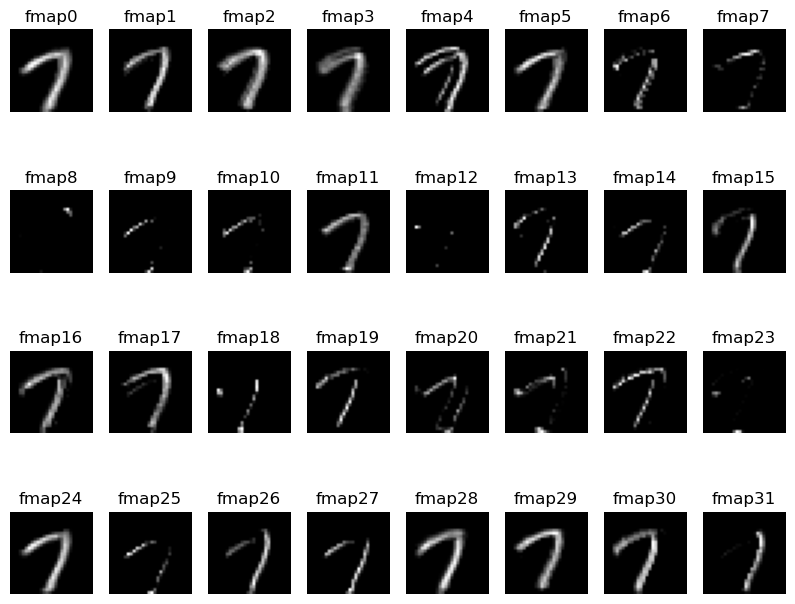

In [12]:
plt.figure(figsize=(10, 8))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(fm[:, :, i], cmap="gray")
    plt.axis("off")
    plt.title("fmap" + str(i))

## (2) 학습 전 pooling map 시각화

In [13]:
partial_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
partial_model.summary()

pooling_map = partial_model.predict(X_test[rnd_idx].reshape(-1,28,28,1))
pooling_map.shape

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 32ms/step


(1, 14, 14, 32)

In [14]:
pm = pooling_map[0]

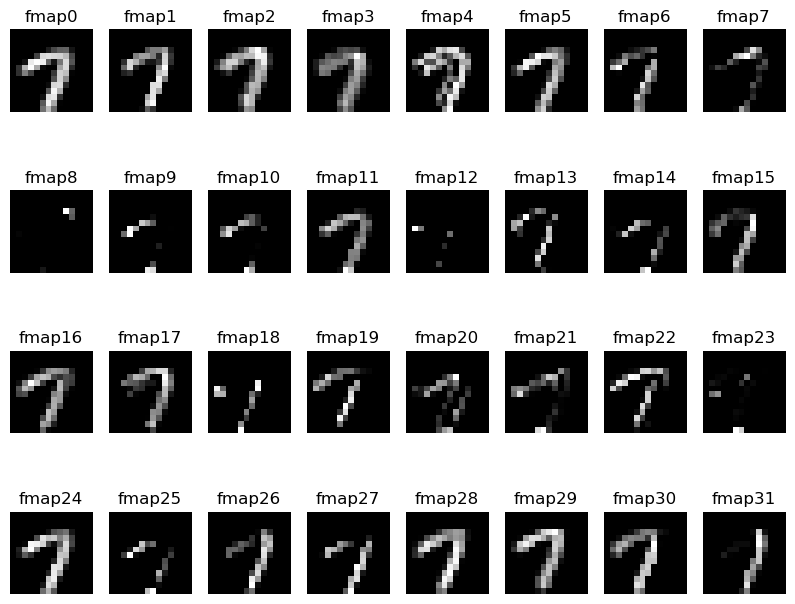

In [15]:
plt.figure(figsize=(10, 8))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(pm[:, :, i], cmap="gray")
    plt.axis("off")
    plt.title("fmap" + str(i))

## (3) 학습 및 평가

In [16]:
from datetime import datetime

start = datetime.now()

result = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=1000)

end = datetime.now()

print("걸린 시간:", end-start)

model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test)

Epoch 1/10
48/48 [==============================] - 17s 337ms/step - loss: 0.5302 - accuracy: 0.8255 - val_loss: 0.0835 - val_accuracy: 0.9754
Epoch 2/10
48/48 [==============================] - 16s 339ms/step - loss: 0.0929 - accuracy: 0.9705 - val_loss: 0.0495 - val_accuracy: 0.9861
Epoch 3/10
48/48 [==============================] - 18s 372ms/step - loss: 0.0655 - accuracy: 0.9787 - val_loss: 0.0422 - val_accuracy: 0.9872
Epoch 4/10
48/48 [==============================] - 17s 352ms/step - loss: 0.0563 - accuracy: 0.9817 - val_loss: 0.0415 - val_accuracy: 0.9880
Epoch 5/10
48/48 [==============================] - 17s 358ms/step - loss: 0.0514 - accuracy: 0.9837 - val_loss: 0.0330 - val_accuracy: 0.9908
Epoch 6/10
48/48 [==============================] - 17s 359ms/step - loss: 0.0434 - accuracy: 0.9856 - val_loss: 0.0341 - val_accuracy: 0.9908
Epoch 7/10
48/48 [==============================] - 18s 371ms/step - loss: 0.0402 - accuracy: 0.9870 - val_loss: 0.0302 - val_accuracy: 0.9914

[0.023227494210004807, 0.9919999837875366]

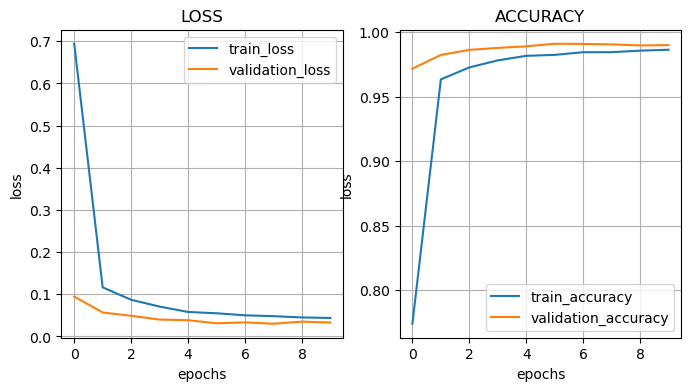

In [17]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

plt.subplot(1,2,2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

## (4) 학습 후

- 학습 후 featur_map

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 17ms/step


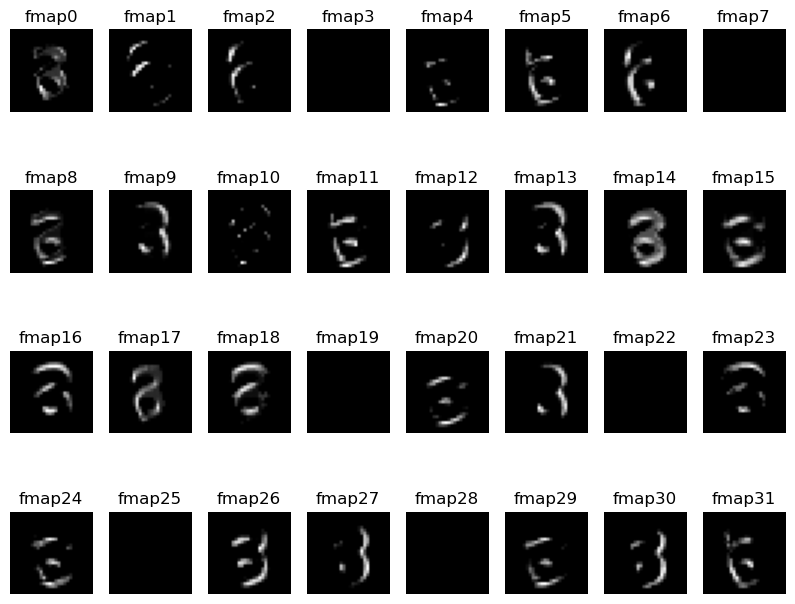

In [18]:
partial_model = Model(inputs=model.inputs, outputs=model.layers[0].output)
partial_model.summary()

feature_map = partial_model.predict(X_test[rnd_idx].reshape(-1,28,28,1))
feature_map.shape

fm = feature_map[0]

plt.figure(figsize=(10, 8))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(fm[:, :, i], cmap="gray")
    plt.axis("off")
    plt.title("fmap" + str(i))

- 학습 후 pooling_map

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 31ms/step


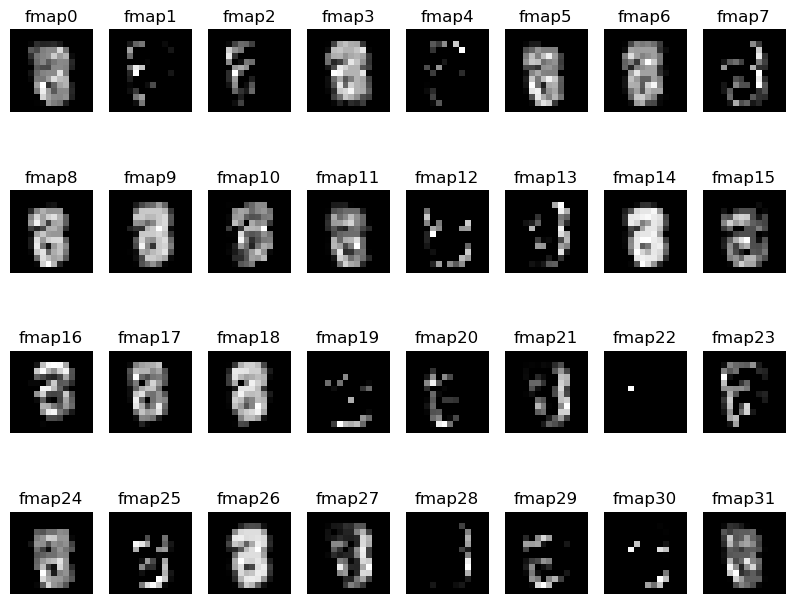

In [19]:
partial_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
partial_model.summary()

feature_map = partial_model.predict(X_test[rnd_idx].reshape(-1,28,28,1))
feature_map.shape

pm = pooling_map[0]

plt.figure(figsize=(10, 8))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(pm[:, :, i], cmap="gray")
    plt.axis("off")
    plt.title("fmap" + str(i))

## (5) 위의 모델을 Model()을 사용하여 변경

In [20]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train / 255
X_test = X_test / 255

In [21]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [19]:
input_ = Input(shape=(28, 28, 1))
c1 = Conv2D(filters=32, kernel_size=3, padding="SAME", activation="relu")(input_)
p1 = MaxPool2D(padding="SAME")(c1)
d1 = Dropout(0.25)(p1)

c2 = Conv2D(filters=64, kernel_size=3, padding="SAME", activation="relu")(d1)
p2 = MaxPool2D(padding="SAME")(c2)
d2 = Dropout(0.25)(p2)

c3 = Conv2D(filters=64, kernel_size=3, padding="SAME", activation="relu")(d2)
p3 = MaxPool2D(padding="SAME")(c3)
d3 = Dropout(0.25)(p3)

f1 = Flatten()(d3)

output_ = Dense(10, activation="softmax")(f1)

model = Model(inputs=input_, outputs=output_)

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                       

# 2. CIFAR10 모델 테스트

In [29]:
try:
    cnn = load_model("data/cifar10_accuray_81v2.h5")
    cnn.summary()
except Exception as err:
    print(str(err))

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_116 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 conv2d_117 (Conv2D)         (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_111 (Dropout)       (None, 14, 14, 32)        0         
                                                                 
 conv2d_118 (Conv2D)         (None, 12, 12, 64)        18496     
                                                                 
 conv2d_119 (Conv2D)         (None, 10, 10, 64)        36928     
                                                     

In [30]:
import cv2
# pip install opencv-python

In [37]:
#src_img1 = cv2.imread("data/cifar10test/airplane_1.jpg", cv2.IMREAD_COLOR)
src_img1 = cv2.imread("data/cifar10test/airplane/airplane_1.jpg", cv2.IMREAD_COLOR)
src_img2 = cv2.imread("data/cifar10test/automobile/automobile_2.jpg", cv2.IMREAD_COLOR)
src_img3 = cv2.imread("data/cifar10test/bird/bird_3.jpg", cv2.IMREAD_COLOR)
src_img4 = cv2.imread("data/cifar10test/cat/cat_4.jpg", cv2.IMREAD_COLOR)
src_img5 = cv2.imread("data/cifar10test/deer/deer_5.jpg", cv2.IMREAD_COLOR)
src_img6 = cv2.imread("data/cifar10test/dog/dog_6.jpg", cv2.IMREAD_COLOR)
src_img7 = cv2.imread("data/cifar10test/frog/frog_7.jfif", cv2.IMREAD_COLOR)
src_img8 = cv2.imread("data/cifar10test/truck/truck_8.jfif", cv2.IMREAD_COLOR)

In [38]:
print(type(src_img1))

<class 'numpy.ndarray'>


In [39]:
print(type(src_img1), src_img1.shape)
print(type(src_img2), src_img2.shape)
print(type(src_img3), src_img3.shape)
print(type(src_img4), src_img4.shape)
print(type(src_img5), src_img5.shape)
print(type(src_img6), src_img6.shape)
print(type(src_img7), src_img7.shape)
print(type(src_img8), src_img8.shape)

<class 'numpy.ndarray'> (667, 1000, 3)
<class 'numpy.ndarray'> (416, 657, 3)
<class 'numpy.ndarray'> (668, 1280, 3)
<class 'numpy.ndarray'> (399, 600, 3)
<class 'numpy.ndarray'> (549, 976, 3)
<class 'numpy.ndarray'> (1252, 2000, 3)
<class 'numpy.ndarray'> (225, 225, 3)
<class 'numpy.ndarray'> (185, 272, 3)


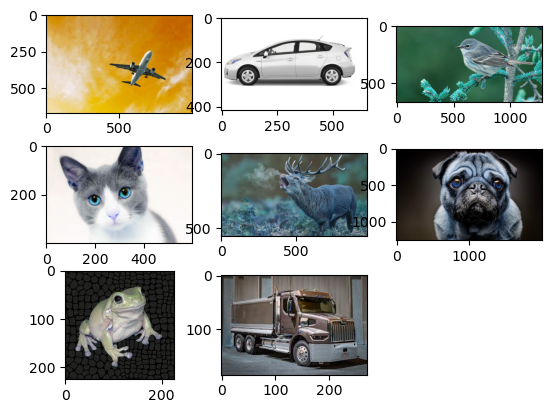

In [40]:
plt.subplot(3, 3, 1)
plt.imshow(src_img1)

plt.subplot(3, 3, 2)
plt.imshow(src_img2)

plt.subplot(3, 3, 3)
plt.imshow(src_img3)

plt.subplot(3, 3, 4)
plt.imshow(src_img4)

plt.subplot(3, 3, 5)
plt.imshow(src_img5)

plt.subplot(3, 3, 6)
plt.imshow(src_img6)

plt.subplot(3, 3, 7)
plt.imshow(src_img7)

plt.subplot(3, 3, 8)
plt.imshow(src_img8)


In [41]:
dst_img1 = cv2.cvtColor(src_img1, cv2.COLOR_BGR2RGB)
dst_img2 = cv2.cvtColor(src_img2, cv2.COLOR_BGR2RGB)
dst_img3 = cv2.cvtColor(src_img3, cv2.COLOR_BGR2RGB)
dst_img4 = cv2.cvtColor(src_img4, cv2.COLOR_BGR2RGB)
dst_img5 = cv2.cvtColor(src_img5, cv2.COLOR_BGR2RGB)
dst_img6 = cv2.cvtColor(src_img6, cv2.COLOR_BGR2RGB)
dst_img7 = cv2.cvtColor(src_img7, cv2.COLOR_BGR2RGB)
dst_img8 = cv2.cvtColor(src_img8, cv2.COLOR_BGR2RGB)


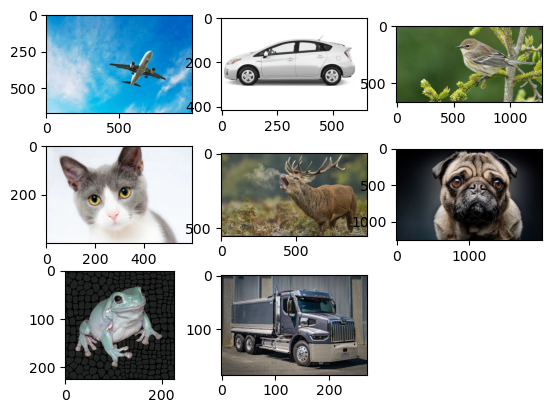

In [42]:
plt.subplot(3, 3, 1)
plt.imshow(dst_img1)

plt.subplot(3, 3, 2)
plt.imshow(dst_img2)

plt.subplot(3, 3, 3)
plt.imshow(dst_img3)

plt.subplot(3, 3, 4)
plt.imshow(dst_img4)

plt.subplot(3, 3, 5)
plt.imshow(dst_img5)

plt.subplot(3, 3, 6)
plt.imshow(dst_img6)

plt.subplot(3, 3, 7)
plt.imshow(dst_img7)

plt.subplot(3, 3, 8)
plt.imshow(dst_img8)


In [43]:
dst_img = [dst_img1,dst_img2,dst_img3,dst_img4,dst_img5,dst_img6,dst_img7,dst_img8]

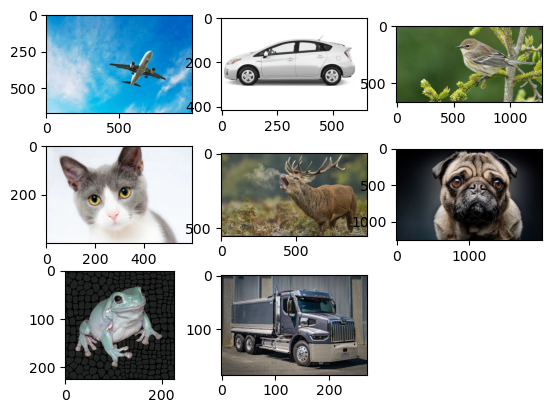

In [44]:
for i in range(8):
    plt.subplot(3, 3, i+1)
    plt.imshow(dst_img[i])

In [45]:
dst_img1 = cv2.resize(dst_img1, dsize=(32,32))
dst_img2 = cv2.resize(dst_img2, dsize=(32,32))
dst_img3 = cv2.resize(dst_img3, dsize=(32,32))
dst_img4 = cv2.resize(dst_img4, dsize=(32,32))
dst_img5 = cv2.resize(dst_img5, dsize=(32,32))
dst_img6 = cv2.resize(dst_img6, dsize=(32,32))
dst_img7 = cv2.resize(dst_img7, dsize=(32,32))
dst_img8 = cv2.resize(dst_img8, dsize=(32,32))


In [46]:
dst_img = [dst_img1,dst_img2,dst_img3,dst_img4,dst_img5,dst_img6,dst_img7,dst_img8]

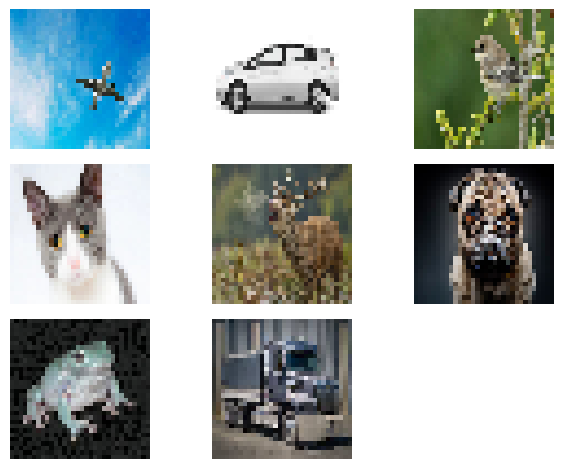

In [47]:
for i in range(8):
    plt.subplot(3, 3, i+1)
    plt.imshow(dst_img[i])
    plt.axis("off")
plt.tight_layout()

In [48]:
print(dst_img1.shape)

(32, 32, 3)


In [49]:
dst_img1 = dst_img1/255.0
dst_img2 = dst_img2/255.0
dst_img3 = dst_img3/255.0
dst_img4 = dst_img4/255.0
dst_img5 = dst_img5/255.0
dst_img6 = dst_img6/255.0
dst_img7 = dst_img7/255.0
dst_img8 = dst_img8/255.0


In [50]:
test_image_list = []

test_image_list.append(dst_img1)
test_image_list.append(dst_img2)
test_image_list.append(dst_img3)
test_image_list.append(dst_img4)
test_image_list.append(dst_img5)
test_image_list.append(dst_img6)
test_image_list.append(dst_img7)
test_image_list.append(dst_img8)


test_image_array = np.array(test_image_list)
print(test_image_array.shape)

(8, 32, 32, 3)


In [51]:
# 예측
pred = cnn.predict(test_image_array)

1/1 [==============================] - 0s 99ms/step


In [52]:
# 예측 확인
print(pred.shape)
print(pred)

(8, 10)
[[8.62498730e-02 1.50203006e-04 1.33259460e-01 9.50039923e-03
  7.50716865e-01 4.49331943e-03 3.04400222e-03 8.95195827e-03
  3.14301718e-03 4.90917824e-04]
 [1.80791099e-20 1.00000000e+00 7.76808513e-27 3.15615752e-33
  9.51001853e-38 1.82786833e-28 2.52847626e-21 1.32828951e-33
  4.57855000e-13 3.83924019e-14]
 [2.72849668e-03 3.64806219e-05 8.81900907e-01 2.52880603e-02
  4.83058095e-02 1.36386594e-02 2.15058159e-02 6.11397112e-03
  3.42633313e-04 1.39304888e-04]
 [7.00308068e-04 5.30912730e-05 7.21616158e-03 8.19594324e-01
  8.21557734e-03 1.53592139e-01 4.42015892e-03 5.56538254e-03
  2.49638018e-04 3.93252762e-04]
 [1.45925884e-03 1.13516282e-04 1.28187120e-01 2.22208813e-01
  4.94100839e-01 4.03615981e-02 1.07933573e-01 5.04743773e-03
  2.04391283e-04 3.83379520e-04]
 [5.83351299e-04 5.46517503e-03 4.97989096e-02 1.82887390e-01
  1.09589528e-02 3.48613560e-01 3.92037243e-01 7.45702954e-03
  1.05110987e-03 1.14739058e-03]
 [1.91139815e-08 3.20993436e-08 1.83005948e-04 1.1

In [53]:
class_name = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

for i in range(len(pred)):
    class_idx = np.argmax(pred[i])
    print(class_name[class_idx], pred[i].max())

deer 0.75071687
automobile 1.0
bird 0.8819009
cat 0.8195943
deer 0.49410084
frog 0.39203724
frog 0.9997029
truck 0.9938257


In [54]:
#### 상위 3개 예측값

In [55]:
top3 = 3

for i in range(len(pred)):
    sorted_index = pred[i].argsort()
    sorted_index = sorted_index[::-1] # 인덱스 내림차순으로 만드는 슬라이싱
    print("=========================================")
    print(sorted_index)
    
    for j in range(top3):
        pred_val = pred[i, sorted_index[i]]
        class_idx = sorted_index[i]
        print("예측값 : ", class_name[class_idx], pred_val)

[4 2 0 3 7 5 8 6 9 1]
예측값 :  deer 0.75071687
예측값 :  deer 0.75071687
예측값 :  deer 0.75071687
[1 8 9 0 6 2 5 3 7 4]
예측값 :  ship 4.57855e-13
예측값 :  ship 4.57855e-13
예측값 :  ship 4.57855e-13
[2 4 3 6 5 7 0 8 9 1]
예측값 :  cat 0.02528806
예측값 :  cat 0.02528806
예측값 :  cat 0.02528806
[3 5 4 2 7 6 0 9 8 1]
예측값 :  bird 0.0072161616
예측값 :  bird 0.0072161616
예측값 :  bird 0.0072161616
[4 3 2 6 5 7 0 9 8 1]
예측값 :  dog 0.040361598
예측값 :  dog 0.040361598
예측값 :  dog 0.040361598
[6 5 3 2 4 7 1 9 8 0]
예측값 :  horse 0.0074570295
예측값 :  horse 0.0074570295
예측값 :  horse 0.0074570295
[6 2 3 4 5 8 1 0 9 7]
예측값 :  automobile 3.2099344e-08
예측값 :  automobile 3.2099344e-08
예측값 :  automobile 3.2099344e-08
[9 1 0 8 3 7 2 5 6 4]
예측값 :  dog 5.6039044e-06
예측값 :  dog 5.6039044e-06
예측값 :  dog 5.6039044e-06


## (1) 이미지 예측에 정답 출력하기
- 파일명을 레이블에 맞게 수정하기
    - 번호를 붙일 경우 _와 같이 분리할 수 있는 기준을 둔다.

In [57]:
# 2. CIFAR10 모델 테스트

try:
    cnn = load_model("data/cifar10_accuray_81v2.h5")
    #cnn.summary()
except Exception as err:
    print(str(err))
    

#### 파일명 불러오기
import glob
    
test_img_list = glob.glob("data/cifar10test/*")

label_list = []
for i in range(len(test_img_list)):
    label_list.append(test_img_list[i].split("\\")[1].split(".")[0].split("_")[0].strip())

print(label_list)
    
# print(test_img_list)
# print(test_img_list[0].split("\\")[1].split(".")[0].split("_")[0].strip())
# print(test_img_list[1].split("\\")[1].split(".")[0].split("_")[0].strip())
    
# 이미지 불러오기
src_img1 = cv2.imread("data/cifar10test/airplane/airplane_1.jpg", cv2.IMREAD_COLOR)
src_img2 = cv2.imread("data/cifar10test/automobile/automobile_2.jpg", cv2.IMREAD_COLOR)
src_img3 = cv2.imread("data/cifar10test/bird/bird_3.jpg", cv2.IMREAD_COLOR)
src_img4 = cv2.imread("data/cifar10test/cat/cat_4.jpg", cv2.IMREAD_COLOR)
src_img5 = cv2.imread("data/cifar10test/deer/deer_5.jpg", cv2.IMREAD_COLOR)
src_img6 = cv2.imread("data/cifar10test/dog/dog_6.jpg", cv2.IMREAD_COLOR)
src_img7 = cv2.imread("data/cifar10test/frog/frog_7.jfif", cv2.IMREAD_COLOR)
src_img8 = cv2.imread("data/cifar10test/truck/truck_8.jfif", cv2.IMREAD_COLOR)

##### RGB에 맞게 순서 조정
dst_img1 = cv2.cvtColor(src_img1, cv2.COLOR_BGR2RGB)
dst_img2 = cv2.cvtColor(src_img2, cv2.COLOR_BGR2RGB)
dst_img3 = cv2.cvtColor(src_img3, cv2.COLOR_BGR2RGB)
dst_img4 = cv2.cvtColor(src_img4, cv2.COLOR_BGR2RGB)
dst_img5 = cv2.cvtColor(src_img5, cv2.COLOR_BGR2RGB)
dst_img6 = cv2.cvtColor(src_img6, cv2.COLOR_BGR2RGB)
dst_img7 = cv2.cvtColor(src_img7, cv2.COLOR_BGR2RGB)
dst_img8 = cv2.cvtColor(src_img8, cv2.COLOR_BGR2RGB)


#
dst_img1 = cv2.resize(dst_img1, dsize=(32,32))
dst_img2 = cv2.resize(dst_img2, dsize=(32,32))
dst_img3 = cv2.resize(dst_img3, dsize=(32,32))
dst_img4 = cv2.resize(dst_img4, dsize=(32,32))
dst_img5 = cv2.resize(dst_img5, dsize=(32,32))
dst_img6 = cv2.resize(dst_img6, dsize=(32,32))
dst_img7 = cv2.resize(dst_img7, dsize=(32,32))
dst_img8 = cv2.resize(dst_img8, dsize=(32,32))


#
dst_img = [dst_img1,dst_img2,dst_img3,dst_img4,dst_img5,dst_img6,dst_img7,dst_img8]

#
dst_img1 = dst_img1/255.0
dst_img2 = dst_img2/255.0
dst_img3 = dst_img3/255.0
dst_img4 = dst_img4/255.0
dst_img5 = dst_img5/255.0
dst_img6 = dst_img6/255.0
dst_img7 = dst_img7/255.0
dst_img8 = dst_img8/255.0


#
test_image_list = []
test_image_list.append(dst_img1)
test_image_list.append(dst_img2)
test_image_list.append(dst_img3)
test_image_list.append(dst_img4)
test_image_list.append(dst_img5)
test_image_list.append(dst_img6)
test_image_list.append(dst_img7)
test_image_list.append(dst_img8)


test_image_array = np.array(test_image_list)
print(test_image_array.shape)

# 예측
pred = cnn.predict(test_image_array)

# 예측 확인
print(pred.shape)
print(pred)

class_name = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

for i in range(len(pred)):
    class_idx = np.argmax(pred[i])
    print(class_name[class_idx], pred[i].max(), " , label=", label_list[i])


#### 상위 3개 예측값
top3 = 3

for i in range(len(pred)):
    sorted_index = pred[i].argsort()
    
    # 내림차순으로 다시 변경
    sorted_index = sorted_index[::-1]
    
    print("===========================")
    
    print(sorted_index, ", 입력 값의 label=", label_list[i])    # 앞에서부터 3개가 높은 값의 인덱스임.
    
    for j in range(top3):
        pred_val = pred[i, sorted_index[j]]
        class_idx = sorted_index[j]
        print("예측값 :", class_name[class_idx], pred_val)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'truck']
(8, 32, 32, 3)
1/1 [==============================] - 0s 96ms/step
(8, 10)
[[8.62498730e-02 1.50203006e-04 1.33259460e-01 9.50039923e-03
  7.50716865e-01 4.49331943e-03 3.04400222e-03 8.95195827e-03
  3.14301718e-03 4.90917824e-04]
 [1.80791099e-20 1.00000000e+00 7.76808513e-27 3.15615752e-33
  9.51001853e-38 1.82786833e-28 2.52847626e-21 1.32828951e-33
  4.57855000e-13 3.83924019e-14]
 [2.72849668e-03 3.64806219e-05 8.81900907e-01 2.52880603e-02
  4.83058095e-02 1.36386594e-02 2.15058159e-02 6.11397112e-03
  3.42633313e-04 1.39304888e-04]
 [7.00308068e-04 5.30912730e-05 7.21616158e-03 8.19594324e-01
  8.21557734e-03 1.53592139e-01 4.42015892e-03 5.56538254e-03
  2.49638018e-04 3.93252762e-04]
 [1.45925884e-03 1.13516282e-04 1.28187120e-01 2.22208813e-01
  4.94100839e-01 4.03615981e-02 1.07933573e-01 5.04743773e-03
  2.04391283e-04 3.83379520e-04]
 [5.83351299e-04 5.46517503e-03 4.97989096e-02 1.82887390e-01
  1.

## (2) 이미지 예측에 정답 출력하기

- 폴더명을 레이블명으로 만들기
- 먼저 탐색기에서 레이블명으로 폴더를 만들고 이미지를 이동시킨다.

### colab에서 작업할 경우

- 우선 이미지 폴더를 압축하여 업로드 한다.

In [59]:
# colab기준으로 작성중

import os
import zipfile
import shutil

# 같은 이름의 폴더가 있을 경우 지워주는 코드 # 에러방지
shutil.remtree("/content/cifar10test")

with zipfile.ZipFile("/content/cifar10test.zip", "r") as target_file:
    target_file.extractall()
    
# 특정 폴더 안에 압축 풀기
with zipfile.ZipFile("/content/cifar10test.zip", "r") as target_file:
    target_file.extractall("/content/cifar10test")

In [ ]:
try:
    cnn = load_model("data/cifar10_accuray_81v2.h5")
    #cnn.summary()
except Exception as err:
    print(str(err))
    

#### 파일명 불러오기
import glob
    
test_img_list = glob.glob("data/cifar10test/*/*")

# 정답 추출
label_list = []
for i in range(len(test_img_list)):
    label_list.append(test_img_list[i].split("\\")[1].strip())

print(label_list)
    
# print(test_img_list)
# print(test_img_list[0].split("\\")[1].split(".")[0].split("_")[0].strip())
# print(test_img_list[1].split("\\")[1].split(".")[0].split("_")[0].strip())
    
# 이미지 불러오기
src_img1 = cv2.imread("data/cifar10test/airplane_1.jpg", cv2.IMREAD_COLOR)
src_img2 = cv2.imread("data/cifar10test/automobile_2.jpg", cv2.IMREAD_COLOR)
src_img3 = cv2.imread("data/cifar10test/bird_3.jpg", cv2.IMREAD_COLOR)
src_img4 = cv2.imread("data/cifar10test/cat_4.jpg", cv2.IMREAD_COLOR)
src_img5 = cv2.imread("data/cifar10test/deer_5.jpg", cv2.IMREAD_COLOR)
src_img6 = cv2.imread("data/cifar10test/dog_6.jpg", cv2.IMREAD_COLOR)
src_img7 = cv2.imread("data/cifar10test/frog_7.jfif", cv2.IMREAD_COLOR)
src_img8 = cv2.imread("data/cifar10test/truck_8.jfif", cv2.IMREAD_COLOR)

##### RGB에 맞게 순서 조정
dst_img1 = cv2.cvtColor(src_img1, cv2.COLOR_BGR2RGB)
dst_img2 = cv2.cvtColor(src_img2, cv2.COLOR_BGR2RGB)
dst_img3 = cv2.cvtColor(src_img3, cv2.COLOR_BGR2RGB)
dst_img4 = cv2.cvtColor(src_img4, cv2.COLOR_BGR2RGB)
dst_img5 = cv2.cvtColor(src_img5, cv2.COLOR_BGR2RGB)
dst_img6 = cv2.cvtColor(src_img6, cv2.COLOR_BGR2RGB)
dst_img7 = cv2.cvtColor(src_img7, cv2.COLOR_BGR2RGB)
dst_img8 = cv2.cvtColor(src_img8, cv2.COLOR_BGR2RGB)


#
dst_img1 = cv2.resize(dst_img1, dsize=(32,32))
dst_img2 = cv2.resize(dst_img2, dsize=(32,32))
dst_img3 = cv2.resize(dst_img3, dsize=(32,32))
dst_img4 = cv2.resize(dst_img4, dsize=(32,32))
dst_img5 = cv2.resize(dst_img5, dsize=(32,32))
dst_img6 = cv2.resize(dst_img6, dsize=(32,32))
dst_img7 = cv2.resize(dst_img7, dsize=(32,32))
dst_img8 = cv2.resize(dst_img8, dsize=(32,32))


#
dst_img = [dst_img1,dst_img2,dst_img3,dst_img4,dst_img5,dst_img6,dst_img7,dst_img8]

#
dst_img1 = dst_img1/255.0
dst_img2 = dst_img2/255.0
dst_img3 = dst_img3/255.0
dst_img4 = dst_img4/255.0
dst_img5 = dst_img5/255.0
dst_img6 = dst_img6/255.0
dst_img7 = dst_img7/255.0
dst_img8 = dst_img8/255.0


#
test_image_list = []
test_image_list.append(dst_img1)
test_image_list.append(dst_img2)
test_image_list.append(dst_img3)
test_image_list.append(dst_img4)
test_image_list.append(dst_img5)
test_image_list.append(dst_img6)
test_image_list.append(dst_img7)
test_image_list.append(dst_img8)


test_image_array = np.array(test_image_list)
print(test_image_array.shape)

# 예측
pred = cnn.predict(test_image_array)

# 예측 확인
print(pred.shape)
print(pred)

class_name = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

for i in range(len(pred)):
    class_idx = np.argmax(pred[i])
    print(class_name[class_idx], pred[i].max(), " , label=", label_list[i])


#### 상위 3개 예측값
top3 = 3

for i in range(len(pred)):
    sorted_index = pred[i].argsort()
    
    # 내림차순으로 다시 변경
    sorted_index = sorted_index[::-1]
    
    print("===========================")
    
    print(sorted_index, ", 입력 값의 label=", label_list[i])    # 앞에서부터 3개가 높은 값의 인덱스임.
    
    for j in range(top3):
        pred_val = pred[i, sorted_index[j]]
        class_idx = sorted_index[j]
        print("예측값 :", class_name[class_idx], pred_val)

# 3. 구글 포토 서비스 프로토타입 구현

- photo 라는 폴더에 이미지를 수집

In [60]:
import cv2

try:
    cnn = load_model("data/cifar10_accuray_81v2.h5")
    #cnn.summary()
except Exception as err:
    print(str(err))

In [61]:
import os

target_root_dir = "data/pred_result"

if not os.path.exists(target_root_dir):
    os.mkdir(target_root_dir)
    print(target_root_dir + "is created!")

In [62]:
class_name = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

for i in range(len(class_name)):
    label_dir = target_root_dir + "/" + class_name[i].strip()
    
    if not os.path.exists(label_dir):
        os.mkdir(label_dir)
        print(label_dir + "is created!")
        
unknown_dir = target_root_dir + "/unknown/"

if not os.path.exists(unknown_dir):
        os.mkdir(unknown_dir)
        print(unknown_dir + "is created!")

In [63]:
# 테스트할 이미지의 압축 풀기
import zipfile

with zipfile.ZipFile("data/photo.zip", "r") as target_file: # 압축을 풀거다
    target_file.extractall("data/photo") # 어디에 압축을 풀것인가?
    print("success!")

success!


In [64]:
import cv2
import glob

src_img_list = []
dst_img_list = []

img_file_list = glob.glob("data/photo/*") # 처리할 사진을 메모리에 넣기
#print(img_file_list) # 읽어오는지 확인

for i in img_file_list:
    src_img = cv2.imread(i, cv2.IMREAD_COLOR)
    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    dst_img = cv2.resize(dst_img, dsize=(32,32))
    dst_img = dst_img / 255.0
    
    print(src_img.shape, dst_img.shape)
    
    src_img_list.append(src_img)
    dst_img_list.append(dst_img)

(183, 275, 3) (32, 32, 3)
(168, 300, 3) (32, 32, 3)
(179, 281, 3) (32, 32, 3)
(1670, 2176, 3) (32, 32, 3)
(508, 590, 3) (32, 32, 3)
(592, 798, 3) (32, 32, 3)
(179, 281, 3) (32, 32, 3)


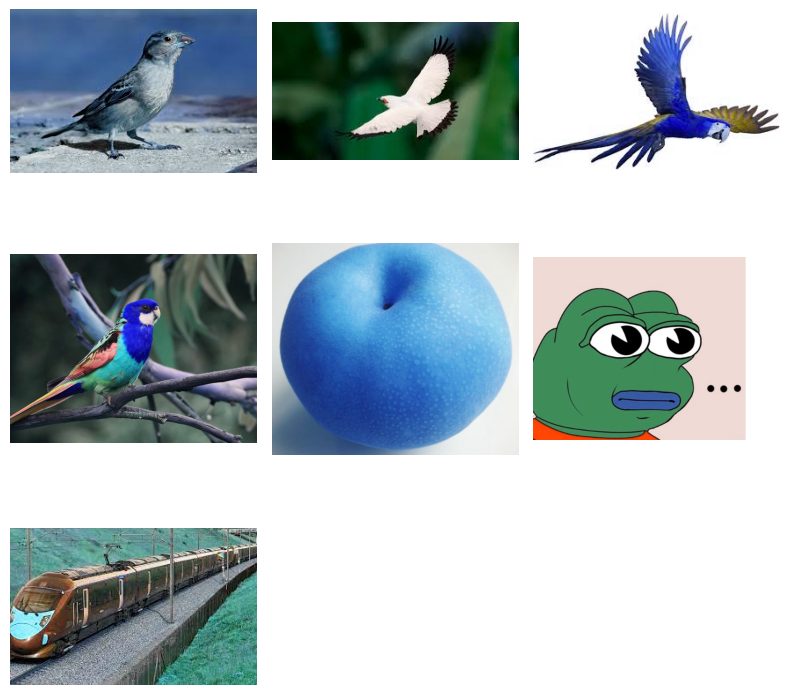

In [65]:
plt.figure(figsize = (8,8))

for i in range(len(src_img_list)):
    plt.subplot(3, 3, i+1)
    plt.imshow(src_img_list[i])
    plt.axis("off")
    
plt.tight_layout()

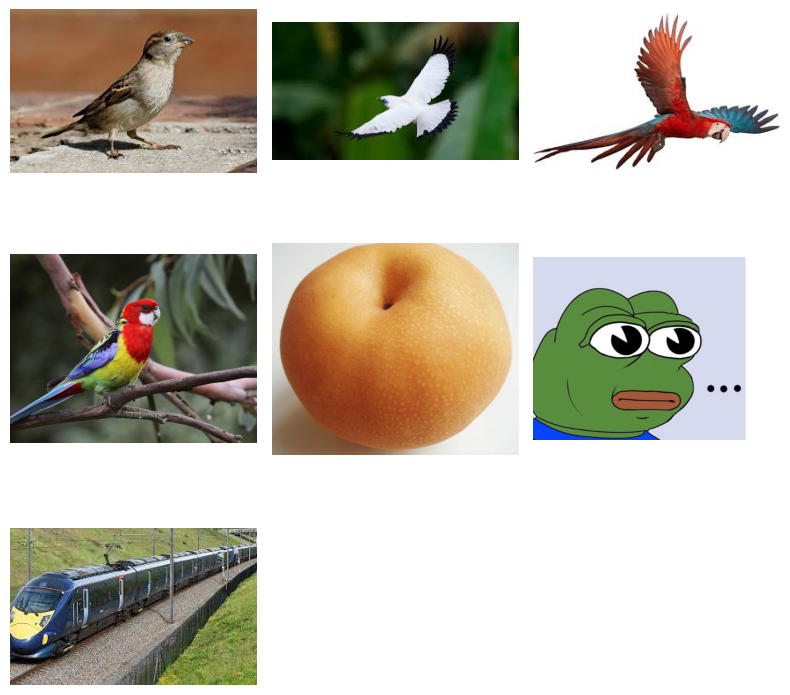

In [66]:
plt.figure(figsize = (8,8))

for i in range(len(src_img_list)):
    plt.subplot(3, 3, i+1)
    temp = cv2.cvtColor(src_img_list[i], cv2.COLOR_BGR2RGB)
    plt.imshow(temp)
    plt.axis("off")

plt.tight_layout()

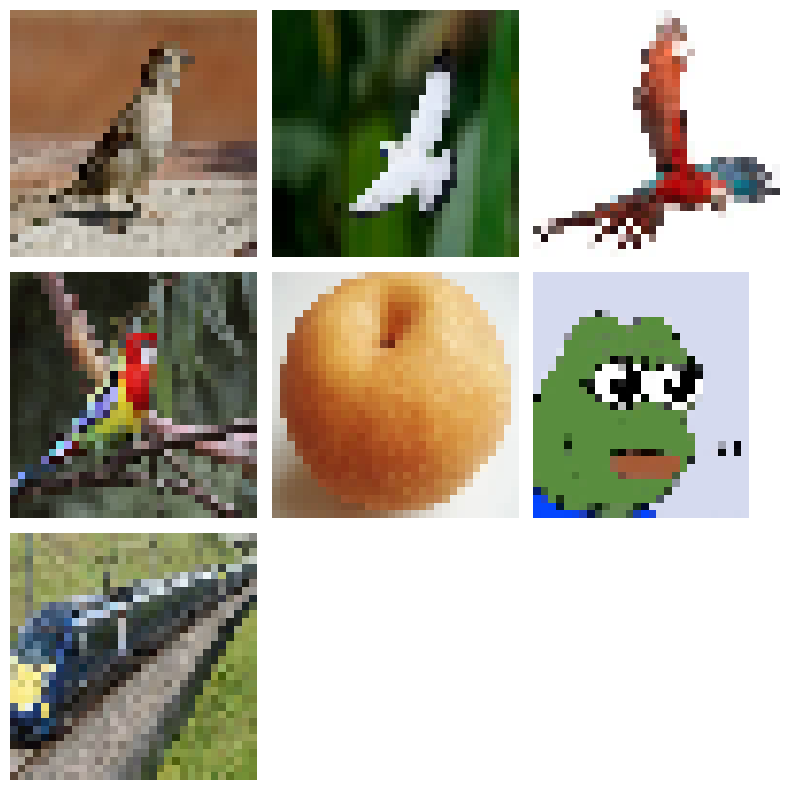

In [67]:
plt.figure(figsize = (8,8))

for i in range(len(src_img_list)):
    plt.subplot(3, 3, i+1)
    plt.imshow(dst_img_list[i])
    plt.axis("off")
    
plt.tight_layout()

In [68]:
dst_img_array = np.array(dst_img_list)
print(dst_img_array.shape)

(7, 32, 32, 3)


In [69]:
# 예측
pred = cnn.predict(dst_img_array)

# 예측 확인
print(pred.shape)
print(pred)

class_name = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

for i in range(len(pred)):
    class_idx = np.argmax(pred[i])
    print(class_name[class_idx], pred[i].max(), " , label=", label_list[i])


#### 상위 3개 예측값
top3 = 3

for i in range(len(pred)):
    sorted_index = pred[i].argsort()
    
    # 내림차순으로 다시 변경
    sorted_index = sorted_index[::-1]
    
    print("===========================")
    
    print(sorted_index, ", 입력 값의 label=", label_list[i])    # 앞에서부터 3개가 높은 값의 인덱스임.
    
    for j in range(top3):
        pred_val = pred[i, sorted_index[j]]
        class_idx = sorted_index[j]
        print("예측값 :", class_name[class_idx], pred_val)

1/1 [==============================] - 0s 101ms/step
(7, 10)
[[1.46553409e-03 6.10405959e-06 9.85783577e-01 2.87248939e-03
  2.53464631e-03 2.81605218e-03 2.77209724e-03 1.56760751e-03
  1.61384494e-04 2.04807275e-05]
 [6.20284071e-03 3.84051760e-04 7.06064522e-01 1.23682134e-01
  1.46798072e-02 6.59991875e-02 6.43680245e-02 1.56390220e-02
  2.32068216e-03 6.59718411e-04]
 [2.68191807e-02 2.00417082e-04 3.56175095e-01 3.92127074e-02
  1.36772186e-01 8.18100795e-02 4.92614042e-03 3.51219803e-01
  2.19040131e-03 6.73976610e-04]
 [6.63875118e-02 2.85394327e-03 1.67236894e-01 5.08796461e-02
  2.15493083e-01 6.61724657e-02 2.01374535e-02 3.99093091e-01
  4.51111561e-03 7.23480294e-03]
 [4.99346934e-04 9.29770158e-06 1.28538841e-02 9.20278609e-01
  1.03863580e-02 4.48620133e-02 8.27760715e-03 2.36376957e-03
  2.79135420e-04 1.90054168e-04]
 [2.50230581e-02 3.91811371e-01 9.74960476e-02 5.00497185e-02
  7.99587183e-03 8.37503374e-02 2.45624453e-01 2.25075595e-02
  3.50294299e-02 4.07121368e-0

In [44]:
dst_img_array = np.array(dst_img_list)
print(dst_img_array.shape)

pred = cnn.predict(dst_img_array)

class_name = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# print(pred.shape)
# print(pred)

label_list = []
for i in range(len(img_file_list)):
    label_list.append(img_file_list[i].split("\\")[1].split(".")[0].strip())
# print(label_list)


for i in range(len(pred)):
    class_idx = np.argmax(pred[i])
    print(class_name[class_idx], pred[i].max(), ', label=', label_list[i]) #

#### 상위 3개 예측값
top3 = 3

for i in range(len(pred)):
    sorted_index = pred[i].argsort()
    
    # 내림차순으로 다시 변경
    sorted_index = sorted_index[::-1]
    
    print("===========================")
    
    print(sorted_index, ", 입력 값의 label=", label_list[i])    # 앞에서부터 3개가 높은 값의 인덱스임. 
    
    for j in range(top3):
        pred_val = pred[i, sorted_index[j]]
        class_idx = sorted_index[j]
        print("예측값 :", class_name[class_idx], pred_val)

(7, 32, 32, 3)
1/1 [==============================] - 0s 99ms/step
bird 0.9857836 , label= bird_2
bird 0.7060645 , label= bird_3
bird 0.3561751 , label= bird_4
horse 0.3990931 , label= bird_5
cat 0.9202786 , label= pear_1
automobile 0.39181137 , label= pepe_1
frog 0.8425993 , label= train_1
[2 3 5 6 4 7 0 8 9 1] , 입력 값의 label= bird_2
예측값 : bird 0.9857836
예측값 : cat 0.0028724894
예측값 : dog 0.0028160522
[2 3 5 6 7 4 0 8 9 1] , 입력 값의 label= bird_3
예측값 : bird 0.7060645
예측값 : cat 0.123682134
예측값 : dog 0.06599919
[2 7 4 5 3 0 6 8 9 1] , 입력 값의 label= bird_4
예측값 : bird 0.3561751
예측값 : horse 0.3512198
예측값 : deer 0.13677219
[7 4 2 0 5 3 6 9 8 1] , 입력 값의 label= bird_5
예측값 : horse 0.3990931
예측값 : deer 0.21549308
예측값 : bird 0.1672369
[3 5 2 4 6 7 0 8 9 1] , 입력 값의 label= pear_1
예측값 : cat 0.9202786
예측값 : dog 0.044862013
예측값 : bird 0.012853884
[1 6 2 5 3 9 8 0 7 4] , 입력 값의 label= pepe_1
예측값 : automobile 0.39181137
예측값 : frog 0.24562445
예측값 : bird 0.09749605
[6 2 8 0 9 1 3 4 5 7] , 입력 값의 label= train_1
예

In [70]:
import shutil

class_name = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

for index in range(len(pred)):
    class_index = np.argmax(pred[index])
    print(class_name[class_index], pred[index].max())
    
    if(pred[index].max() >= 0.5):
        target_dir = target_root_dir + "/" + class_name[class_index].strip()
        shutil.copy(img_file_list[index], target_dir)
        filename = img_file_list[index].split('\\')[1].strip()
        print("{} is copied into {}".format(filename, target_dir))
        
    else:
        target_dir = target_root_dir + "/unknown"
        shutil.copy(img_file_list[index], target_dir)
        filename = img_file_list[index].split('\\')[1].strip()
        print("{} is copied into {}".format(filename, target_dir))
    

bird 0.9857836
bird_2.jfif is copied into data/pred_result/bird
bird 0.7060645
bird_3.jfif is copied into data/pred_result/bird
bird 0.3561751
bird_4.jfif is copied into data/pred_result/unknown
horse 0.3990931
bird_5.jpg is copied into data/pred_result/unknown
cat 0.9202786
pear_1.jpg is copied into data/pred_result/cat
automobile 0.39181137
pepe_1.png is copied into data/pred_result/unknown
frog 0.8425993
train_1.jfif is copied into data/pred_result/frog
